# Object Detection Models

## Introduction

For this project, the aim would be to go through the techniques that are used for object detection in a scene or an image. The techniques that are explored here are the __You Only Look Once (YOLO)__ and __Regions with Convolutional Neural Networks (R-CNN)__. 

The process of detecting ojects in an image or video stream coupled with their bounding boxes is what object detection. Object detection is also called object locatlisation. A bounding box is a small rectangle that surrounds the object in question/interest. Here, the input for the algorithm is usually an image and the output would be a list of bounding boces and the object classes/labels. For each of the bounding boxes, the model should be able to output the corresponding predicted class/label and its confidence that the guess it correct. 

Object detection in general are widely used in industry. For example, these models can be used in the following:
1. Self driving car - for perceiving vehicles and pedestrians.
2. Content moderation - to locate forbidden objects in the scene and its respectiv size.
3. Healthcare - detecting tumors or dangerous unwanted tissues from radiographs.
4. Manufacturing - used in assembly robots of the manufacturing chain to put together or repair products.
5. Security - to detect threats, threspasses, or count people.
6. Wildlife Conservation - to monitor the population of animals.

## Breakdown of this Notebook:
- History of the object detection techniques.
- The main approaches in object detection.
- Implementing the YOLO Architecture for fast object detection task.
- Improving upon YOLO with the Faster R-CNN architecture.
- Utilising the Faster R-CNN with the TensorFlow Object Detection API.


### Import the required libraries:

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import timeit
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2

In [ ]:
import os
from IPython.display import display, Image
import matplotlib.pyplot as plt

# %matplotlib inline

# Set up the working directory for the images:
image_folderName = 'Description Images'
image_path = os.path.abspath(image_folderName) + '/'

In [ ]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

# Set to run or not run the code block: for code examples only. (0 = run code, and 1 = dont run code)
dont_run = 0

### GPU Information:

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
devices = sess.list_devices()
devices

### Use RTX_GPU Tensor Cores for faster compute: FOR TENSORFLOW ONLY

Automatic Mixed Precision Training in TF. Requires NVIDIA DOCKER of TensorFlow.

Sources:
- https://developer.nvidia.com/automatic-mixed-precision
- https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#framework

When enabled, automatic mixed precision will do two things:

- Insert the appropriate cast operations into your TensorFlow graph to use float16 execution and storage where appropriate(this enables the use of Tensor Cores along with memory storage and bandwidth savings). 
- Turn on automatic loss scaling inside the training Optimizer object.

In [ ]:
# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

EXAMPLE CODE: 

In [ ]:
# # Graph-based example:
# opt = tf.train.AdamOptimizer()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# train_op = opt.miminize(loss)

# # Keras-based example:
# opt = tf.keras.optimizers.Adam()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# model.compile(loss=loss, optimizer=opt)
# model.fit(...)

### Use RTX_GPU Tensor Cores for faster compute: FOR KERAS API

Source:
- https://www.tensorflow.org/guide/keras/mixed_precision
- https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/experimental/Policy

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [ ]:
# # Set for MIXED PRECISION:
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

## 1 - History of Object Detection:

In the past, classical computer vision techniques for object detection uses image descriptors, this is where to detect an object like a bike would require several images of this object. The term descriptors refers to the bike object that would be extracted from the image and that these descriptors represents different parts of the bike. As the algorithm looks for the object (bike), it will try to find the descriptors in the target images. 

The most common technique at the time was the usage of the floating window. It is where small rectangular areas of the images were examined one by one, where the part that matches the descriptors the most would be considered to contain the object of interest. This technique have a few advantage at the time, where it was robust to rotation and colour changes in the images, it also does not require a lot training data samples and overall, it worked for most objects. The drawback was that the level of accuracy was not good enough. Soon Neural Networks outpaced this tradiational technique.

Modern algorithms can be seen to have better performance, where this refers to the following:
1. Bounding Box Precision - it provides the correct bounding box where it is not too large or narrow.
2. Recall - it is able to find all the objects.
3. Class Prediction - it is able to output the correct class/label for each of the found object.
4. Speed of the algorithm - it is where the models are getting faster and faster at computing the results so that it can be used in real time. (real time = 5fps for computer vision tasks.)

## 2 - Evaluating the Object Detection model's Performance:

Before diving into YOLO's architecture or going further, it is important to cover some basics in model evaluation that are related to the YOLO model. Evaluating an object detection model will require more than accuracy of the prediction against the ground truth, these extra metrics to be included here are called __Precision__ and __Recall__. These will serve as the basis to compute other metrics that are important to object detection. 

## 2.1 - Precision and Recall Metrics:

To begin with, here are the formulas for these metrics:

$$ precision = \frac{TP}{TP - FP} $$

and

$$ recall = \frac{TP}{TP - FN} $$

where here,

- TP = Number of True Positives (like how many prediction are matching the ground truth of the same class) 
- FP = Number of False Positives (like how many prediction that do not match the ground truth for the same class)
- FN = Number of False Negatives (like how many ground truths do not have a matching prediction)

Additionally, which is not included in the formulas above, but are used in other areas/topics:
- TN = Number of True Negatives (like how many ground truths are actualy a negative example)

If the predictions are exactly matching the ground truthss, both FP and FN won't exist. In this case following the formulas, both precision and recall would equal to 1, leading to a perfect score. 

When a model's predictions comes from non-robust features during its training, the precision of the overall model will decrease because there will be a rise in false positives. In contrast, if the model is too strict where it detects only under precise conditions are met, the recall will decrease due to a rise in false negatives.

## 2.2 - Precision and Recall Curve:

Precision-Recall curves are used to summarise the trade off between the TP rate and the posistive predictive calue for a model by using different probability thresholds. The ideal model should have both high precision and high recall, however, most models often have a trade off between the two. One way to tell how well the model is performing is to compare the area under the curve (AUC) of the chart, where if the area is larger then it performs better or is a better classifier. Below shows a chart that compares two models where the BLUE line model is a better model compared to the GREEN line model. 

Source: 
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- https://www.geeksforgeeks.org/precision-recall-curve-ml/

<img src="Description Images/Precision Recall Curve.png" width="350">

Image Ref -> https://www.geeksforgeeks.org/precision-recall-curve-ml/

Since the general idea is to visualise the performance (precision and recall) at each threshold of confidence, where for every output bounding box, the model will also output a confidence (between 0 and 1, where 1 is more confident). In practice it is a good idea to remove less confident predictions and this is done by setting a certain threshold (T = 0.48 or 0.4) so that any predictions below this number will be removed. 

Changing the value of the threshold will impact the model's precision and recall, where for:
1. __If T = close to 1__: The Precision will be high and the Recall will be low. This means that many objects will be filtered out and the model will miss it as only the confident predictions are kept.
2. __If T = close to 0__: The Recall will be high and the Precision will be low. This means that most of the predictions will be kept and there will not be any false negatives. This directly contributes to the rise of false positive results where the model is less confident in its predictions. 

The choice of this threshold is also high reliant on the problem at hand (classification task). For example, for a model to detect pedestrians, the ideal model would have a high recall rate so not to misss any passers-by, even if the car have to stop for no reason. For a model to detect investment opportunities, the ideal model will have a high precision rate to make sure that it doesn't miss good opportunities and avoids the wrong opportunities.

## 2.3 - Average Precision and Mean Average Precision:

For convenience in practice, often a single number to describe what is happening is very useful. In these cases there are
two terms to consider using: 

1. __Average Precision (AP)__: is the area under th curve and it is always between 0 and 1. This was meantioned earlier. It gives a good indicator of the model performance for a __Single__ class.
2. __Mean Average Precision (mAP)__: is the mean of the average precision for __each__ of the classes. It provides an overall __global scor__. 

## 2.4 - Average Precision Threshold: Jaccard Index (or Intersection over Union, IoU)

The __Jaccard Index__ or __Intersection over Union (IoU)__ is the common metric that is used to measure when a prediction and ground truth are matching. This also defines the TP and FP metrics earlier. The following equation defines the IoU a:

$$ IoU(A, B) =  \frac{\lvert{A \cap B}\rvert}{\lvert{A \cup B}\rvert} = \frac {\lvert{A \cap B}\rvert}{\lvert{A}\rvert - \lvert{B}\rvert - \lvert{A \cap B}\rvert} $$

Where here,
- $\lvert{A}\rvert$, is the cardinality of set A. The number of elements A contains.
- $\lvert{B}\rvert$, is the cardinality of set B. The number of elements B contains.
- $\lvert{A \cap B}\rvert$, is the numerator for number of elements that are in common between A and B. Here $A \cap B$ is the intersection between the two sets.
- $\lvert{A \cup B}\rvert$, is the demoninator for total number of elements that A and B sets covers. Here $A \cup B$ is the union of the sets.

#### The following diagram shows Precision, Recall and IoU:

<img src="Description Images/IoU intersection.PNG" width="600">

Image Ref -> http://www.gabormelli.com/RKB/Bounding_Box_Intersection_over_Union_(IoU)_Measure

Generally, the IoU are used in the computation rather than just the intersections, because the intersections value is absolute but not relative, meaning that two big boxes have more overlapping pixels than two smaller boxes, so the ratio is used instead as it is relative. IoU will always be between 0 and , where 0 if the two boxes does not overlap and 1 if the boxes overlaps completely.

## 3 - YOLO Detection Algorithm: 

YOLO which stands for You Only Look Once algorithm, is one of the fasted object detection algorithm that are available. One a decent GPU, it will be able to achieve >100 FPS (frames per second) for an image sized at 256 by 256 pixels. YOLO is not only fast but accurate too, it has several iterations over the last few years from 2015 to 2018, where the current version is v3. 

The main creator for the YOLO paper maintains the network framework (Called Darknet) here: https://github.com/pjreddie/darknet.

## 3.1 - Advantages and Disadvantages of YOLO:

As mentioned before, the YOLO model is praised for its speed, however, recently this model was outperformed by Fast R-CNN because it performs better than YOLO on detection of smaller objects. Another disadvantage is that the model struggles to classify objects that deviate from the original training dataset. 

## 3.2 - Main Concepts of YOLO:

From their paper (link below), they tackled the problem differently by "reframing object detection as a single regression problem". This essentially means that rather than using a sliding window or other techniques, the input image is divided into a width x height grid. This can be seen in the diagram below:

<img src="Description Images/YOLO Grid.PNG" width="350">

Image Ref -> https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/

As it can be seen in each part of the grid, the bounding boxes are defined. This is then followed by predicting the (i) entre of the box, (ii) the width and height of the box, (iii) probability that there is an object within the box, and (iv) lastly the class of the object itself. It is because these predictions are computed as numbers, the problem can be transformed into a regression problem as stated. This covers roughly the basics of the YOLO's concept in detecting objects, there are also more complex issues such as, more than one object in the grid, overlapping objects in several parts of the grid, or how to train the loss for this model? 

Source: 
- https://arxiv.org/pdf/1506.02640v5.pdf
- https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

For the purpose of simplicity the model will be broken down into two parts, begining with the __Inference__ and then the __Training__ later on.

## 3.3 - YOLO Architecture: Part 1 Inference.

The YOLO architecture itself is based on a __Backbone model__ like most other CNNs, where the backbone model is the feature extractor that will extract meaningful features from the input images that will be used by the final layers later on. The feature extractor architecture here can be anything, but the official YOLO feature extractor uses its own custom backbone. Changing or altering the feature extractor can lead to different performance numbers. Below is a diagram that shows YOLO's model architecture:

<img src="Description Images/YOLO Architecture.PNG" width="850">

Image Ref -> http://datahacker.rs/how-to-peform-yolo-object-detection-using-keras/

The feature extractor's final layer will output a feature volume of size width x height x depth (w x h x D), where the width x height is the size of the grid and D is the depth of the feature volume. The size of the grid (w x h) will depend on the following two factors:

- Stride of the complete feature extractor.
- Size of the input image (smaller the input image, the smaller the grid).

The final layers of the model will take the feature volume as its input. The final layers are composed of 1x1 convolutional filters, which changes the depth of the feature volume without affecting its spatial structure.

## 3.4 - Outputs:

The final outputs from the model is sized as width x height x M (or w x h x M). The (w x h) is the grid size and $M = B * (C + 5)$. Where here, B is the number of bounding boxes per grid cell, C is the number of classes. Notice that there is a number 5 added to the number of classes. This is because, for each of the bounding boxes there is a need to predict (C + 5) of the following numbers:

1. $t_{x}$ and $t_{y}$ - is to compute the coordinates of the centre of the bounding box.
2. $t_{w}$ and $t_{h}$ - is to compute the width and height of the bounding box.
3. c - is the confidence of the object in the box.
4. $p1, p2, ..., $ and $pC$ - are  the probability that the bounding box has the object of class 1, 2, ..., C (where C = 20 for the  dataset classes).

Alternatively, $M = B * (C + 5)$ can be broken down further as $M = B * (C + 4 + 1)$. Where here, B is the number of bounding boxes per grid cell, C is the number of classes, 4 is for the bounding boxes and 1 is the objectness prediction.

Below the diagram summarises the output matrix:

<img src="Description Images/YOLO final matrix output.PNG" width="850">

Image Ref -> http://datahacker.rs/deep-learning-bounding-boxes/ and https://www.cnblogs.com/ranjiewen/p/7896398.html

## 3.5 - Anchor Boxes:

Prior to computing the final bounding boxes as mentioned above, the YOLO architecture also employs the concept of __Anchor Boxes__. This technique was because in version 1 of YOLO, many errors (because the objects varried in sizes) cropped up by directly computing the bounding box coordinates: $t_{x}, t_{y}, t_{w}, t_{h}$. Most of the objects in the training set were to big which resulted in larger bounding boxes, and the model would fail to draw these boxes around smaller objects. YOLO version 2 utilised Anchor Boxes to fix this issue.

__Anchor Boxes (a.k.a Priors) are a set of bounding boxes__ that were decided before training the network, and consists of 3 to 25 different sizes. The network will then refine these anchor boxes to find the closest matching ones for the object in the image. For example, in the image below, a set of 5 bounding boxes were picked to detect the car. As these boxes do not exactly match the object, the network will be required to refine the closest matching anchor box. 

<img src="Description Images/YOLO Anchor Box Example 1.PNG" width="350">

Image Ref -> https://www.jeremyjordan.me/object-detection-one-stage/

In this example, the network will need to correct the height and a small portion of the width of the anchor box. These are what the coordinates, $t_{x}, t_{y}, t_{w}, t_{h}$, previously mentioned above, they are the __corrections to the anchor box__ on the object. For YOLO version 2, the creators realised that sizes of anchor boxes are different for each dataset, therefore it was recommended that the data is to be analysed first to pick the size of the anchor boxes.

## 3.6 - Refining the Anchor Boxes:

The refinement process of these anchor boxes in practice are computed with the following equations:

$$ b_{x} = sigmoid(t_{x} + c_{x}) $$
$$ b_{y} = sigmoid(t_{y} + c_{y}) $$

$$ b_{w} = p_{w}exp(t_{w}) $$
$$ b_{h} = p_{h}exp(t_{h}) $$

Where here,
- $t_{x}, t_{y}, t_{w}, t_{h}$ are the outputs from the last layer.
- $b_{x}, b_{y}, b_{w}, b_{h}$ are the position and size of the predicted bounding box.
- $p_{w}$ and $p_{h}$ are the original size of the anchor box.
- $c_{x}$ and $p_{y}$ are the coordinates of the current grid cell, like (0, 0) for the top left box, (w-1, ) for the top right box, and (0, h-1) for the bottom left box.
- $exp$ is the exponential function.
- $sigmoid$ is the sigmoid function.

Below is a diagram to show how these equations are use:

<img src="Description Images/YOLO Anchor Boxes refinement.PNG" width= "400">

Image Ref -> https://arxiv.org/pdf/1612.08242v1.pdf

The output matrix of the neural network would need to be transformed into a list of boudning boxes, it also needs to be ran for every inference for the computation of the bounding boxes for an image, and below is a simplified version of the code:

In [ ]:
# Converting the numbers of an output matrix from Neural Network to a list of bounding boxes:
if dont_run == 1:
    
    boxes = []
    for row in range(grid_height):
        for col in range(grid_width):
            for b in range(nb_box):
                tx, ty, tw, th = network_output[row, col, b, :4]
                box_confidence = network_output[row, col, b, 4]
                class_scores = network_output[row, col, b, 5:]
                
                # Bounding Boxes
                bx = signmoid(tx) + col
                by = sigmoid(ty) + row
                
                # Anchor boxes are a list of dict consisting of the size of each anchor:
                bw = anchor_boxes[b]['w'] * np.exp(tw)
                bh = anchor_boxes[b]['h'] * np.exp(th)
                
                boxes.append( (bx, by, bw, bh, box_confidence, class_scores))
    

## 3.7 - Post-processing the Bounding Boxes:

Before the boxes can be displayed, it will require a futher post-processing. From the above, the list consists of the cordinates, size of the predicted boxes, confidence and the class probabilities. However, right now, the class probabilities also includes predictions that are less confident or wrong, so these will need to be excluded. Utilising these, the confidence and the class probabilities are then multiplied firstly, then a threshold is used to include only those that are of greater probabilities.

Below is the code to show this example:

In [ ]:
if dont_run == 1:
    
    # The confidence is a float variable, Classes are an array of the size equivalent to the nb_classes:
    final_scores = box_confidence * class_scores
    
    # Set the Threshold:
    OBJECT_THRESHOLD = 0.3
    
    # Filter out the lower probabilities and keep the ones that are greater than the threshold:
    filter_classes = class_scores >= OBJECT_THRESHOLD
    
    filtered_scores = class_scores * filter_classes
    
    # If the filtered scores contains non-null values, it means that at least one class is above the threshold and this is kept:
    class_id = np.argmax(filtered_scores)
    class_label = CLASS_LABELS[class_id]

After applying the filtering/post-processing to all of the bounding boxes in the grid, all the information can be used to draw the predictions. The following shows the output from this stag:

<img src="Description Images/YOLO ouput bounding boxes before NMS.png" width="350">

Image Ref -> https://towardsdatascience.com/guide-to-car-detection-using-yolo-48caac8e4ded

As it can be seen, there are numerous bounding boxes that are overlapping the objects in the grid. This is an outcome of the object occupying multiple grid boxes and therefore will have multiple bounding boxes overlapping each other. In order to correct this and clean up the image, the last stage of the post-processing pipeline is the __Non-Maximum Supression (NMS)__.

## 3.8 - Non-Maximum Supression (NMS):

The NMS post-processing procedure is to remove all the other unwanted bounding boxes (with the lowest probability) and keep only the bounding box with the highest probability. This is why it is call __Non-Maximum__ as it removes the boxes with lower probabilities. This can be done by firstly sorting out all the boxes by its probability, then taking the boxes with the highest probability. Next, for each of the box chosen, proceed to compute the __Intersection over Union (IoU)__ with all the other boxes.

Once the IoU(s) are computed between a box and the other boxes, the ones with an IoU value that is above a certain threshold (typically, 0.5 to 0.9) will be removed.

The following shows an example code for the NMS:

NOTE: In practice, TensorFlow has its own implementation of NMS called "tf.image.non_max_supression(boxes, ...)"

In [ ]:
if dont_run == 1:
    
    # Sort the bounding boxes:
    sorted_boxes = sort_boxes_by_confidence(boxes)
    ids_to_suppress = []
    
    # Compute the IoU:
    for maximum_box in sorted_boxes:
        for idx, box, in enumerate(boxes):
            iou = compute_iou(maximum_box, box)
            
            if iou > iou_threshold:
                ids_to_suppress.append(idx)
                
    # Delete the unwanted boxes:
    processed_boxes = np.delete(boxes, ids_to_suppress)

After post-processing with NMS, the object now has only one bounding box surrounding it. This can be seen in the image below:

<img src="Description Images/YOLO ouput bounding boxes after NMS.png" width="600">

Image Ref -> https://towardsdatascience.com/guide-to-car-detection-using-yolo-48caac8e4ded

## 3.9 - Summary of YOLO Inference:

Before diving into YOLO training phase, this section will summarise all the steps taken. 

1. Input image enters the CNN backbone to compute the feature volumes.
2. Using the convolutional layer to compute the anchor box corrections, objectness scores, and class probabilities.
3. Using the output matrix to compute the coordinates of the bounding boxes.
4. Filter out the lower threshold boxes and post-process them with NMS to obtain the highest probability bounding box over the object.

It should be noted that this whole process is composed of convolutions and filtering operations throughout, which means that the model can ingest images of any size and ratios, giving the property of flexibility.

## 4 - YOLO Architecture: Part 2 YOLO Training.

The YOLO model is composed of two parts, where the first is the backbone and the second is the YOLO head. As for the backbone architectures, many types can be used. Typically before training the full YOLO model, the backbone would be trained first, on a classsification task with pretrained weights of ImageNet as this speeds up the computation time. 

Keras can be employed to train the backbone based on the pretrained wweights of ImageNet, the following shows an example:

In [ ]:
if dont_run == 1:
    
    # Define the input image shape:
    input_image = Input(shape = (IMAGE_H, IMAGE_W, 3))
    
    # Define the True Box for the objects:
    true_boxes = Input(shape = (1, 1, 1, TRUE_BOX_BUFFER, 4))
    
    # Instantiate the Backbone CNN model: Inception model v.
    inception = InceptionV3(input_shape = (IMAGE_H, IMAGE_W, 3),
                            weights = 'imagenet',
                            include_top = False)
    
    # Get the output feature volumes from the inception model:
    features = inception(input_image)
    
    # Get the out shape:
    GRID_H, GRID_W = inception.get_output_shape_at(-1)[1:3]
    
    # Get the output with the bounding box:
    output = Conv2D(BOX * (4 + 1 + CLASS), 
                    (1, 1),
                    strides = (1, 1),
                    padding = 'same',
                    name = 'DetectionLayer',
                    kernel_initializer = 'lecun_normal')(features)
    
    # Reshape the output:
    output = Reshape( (GRID_H, GRID_W, BOX, 4 + 1 + CLASS) )(output)

## 4.1 - YOLO Loss:

Immediately it can be seen that the output of the last layer is unusual compared to model that were implemented in previous notebooks, therefore the corresponding loss here will also be unusual. Note that the YOLO loss is quite complex and will be required to be broken down into several parts. Each of these corresponding loss outputs will be returned by the last layer.

The YOLO network will predict the following kinds of information:
- Bounding box coordinates and its size. (__Bounding Box Loss__)
- Cofidence that the object of interest is in the bounding box. (__Object Confidence Loss__)
- Scores of the classes. (__Classification Loss__)
- Full YOLO Loss.

In general, the loss computed here should be high when the error is high and the loss will be used to penalise the incorrect values. However, with YOLO, the loss should only penalise when it makes sense to do so, such as if the bounding box contains no objects, there is no need to penalise its coordinates as it won't be utilised anyway. 

NOTE: As the source paper does not include how the loss is computed, it is better to check other sources of their loss implementation as there are several that works.

### 4.1.1 - Boudning Box Loss:

This first loss aids the model to learn the weights so that it can be used to predict the bounding box coordinates and its size. Key to this loss equation would be the __indicator function__, where the computed coordinates will only be correct when the box is responsible in detecting an object. The key part of this loss computation is the indicator function, where the coordinates will be correct if the box is responsible for detecting an object. Taking the instance of YOLO v1, it had difficulty in determining the correct bounding box to use, and in YOLO v2, it was resolved by using the highest IoU with the detected object. The goal here is to ensure that each objectof interest will have its own anchor boxes.

The following equation shows the loss at this stage:

$$ \lambda_{coord} \sum^{S^{2}}_{i=0} \sum^{B}_{j=0} 1_{ij}^{obj} [(x_{i} -\hat{x_{i}})^{2}] + \lambda_{coord} \sum^{S^{2}}_{i=0} \sum^{B}_{j=0} 1_{ij}^{obj} [(\sqrt{w_{i}} - \sqrt{\hat{w_{i}}})^{2} + (\sqrt{h_{i}} - \sqrt{\hat {h_{i}}})^{2}] $$

Where here,
- $ \lambda_{coord} $ is the weighting of the loss, it determines how much importance is given to the bounding box coordinates during training.
- $ \sum^{S^{2}}_{i=0} \sum^{B}_{j=0} $ is the sum for each part of the grid (from i = 0 to i = $S^{2}$) and for each box in this part of the grid (from 0 to B).
- $ 1_{ij}^{obj} $ is the indicator function for objects, it is equal to 1 when the $i^{th}$ part of the grid and the $j^{th}$ bounding box are responsible for an object.
- $ x_{i}, y_{i}, w_{i}m h_{i}$ is the bounding box size and coordinates. The difference between the predicted value (hat^) from the ouput of the network and the target value (ground truth). 
- $ Square Root $ ensures that the values are positive.
- By taking the square root of $w_{i}$ and $h_{i}$, it ensures that the errors for small bounding boxes are penalised more heavily compared to larger bounding boxes.

### 4.1.2 - Object Confidence Loss:

The next loss computation will have the network learn the weights that predicts if the bounding box contains an object.

The following equation shows the loss equation:

$$ \lambda_{obj} \sum^{S^{2}}_{i=0} \sum^{B}_{j=0} 1_{ij}^{obj} [(C_{ij} -\hat{C_{ij}})^{2}] + \lambda_{noobj} \sum^{S^{2}}_{i=0} \sum^{B}_{j=0} 1_{ij}^{noobj} [(C_{ij} -\hat{C_{ij}})^{2}] $$

Where here,
- $C_{ij}$ is the confidence that the box (j) in the part (i) of the grid does contain an object.
- $1_{ij}^{noobj}$ is the indicator function for no object, it will equal to 1 when the $i^{th}$ part of the gird and the $j^{th}$ bounding box are not responsible for an object.

In order to ensure that the objectness score is not penalised when there are other good candidates that also fits the object of interest, the $1_{ij}^{noobj}$ can be defined as seen below:

$$ 1_{ij}^{noobj} == \{^{1 (box is not responsible for any object) and (box not overlapping too much with any object bounding box)}_{0 (otherwise)}$$

Note that in practice, for each of the bounding box (i, j), the IoU w.r.t the ground truth boxes is computed. If the IoU is over the threshold (e.g. 0.6), $1_{ij}^{noobj}$ would be set to 0. This ensures to avoid penalising the boxes that contain objects but are not responsible for the object of interest.

### 4.1.3 - Classification Loss:

The last part of the loss computation is the classification loss which have the network learning to predict the proper class for each of the bounding box. The following shows the loss equation:

$$ \sum^{S^{2}}_{i=0} 1_{i}^{obj} \sum_{c \epsilon classes} (p_{i}(c) - \hat{p_{i}}(c))^{2} $$

NOTE: the original YOLO paper utilised L2 loss while many other implementations were using cross-entropy.

### 4.1.4 - Full YOLO Loss:

With the above three loss equations stated, the final overall loss is computed by summing the three losses together. This means that the combination computes the loss penalises the error of the bounding box coordinate refinement, objectness scores and the class prediction. By backpropagating this error, the YOLO model can be trained properly to predict the correct bounding boxes for the correct objects.

## 5 - Techniques used for Training:

Using the loss, the YOLO model can be trained through backpropagation. To ensure that the loss does not diverge away and that good performance were to be obtained, techniques such as:

1. Augmentation, is used to prevent overfitting the dataset.
2. Multi-scaling training, where for every "n" batches, the network's input is changed to a different siz, which ensures the model learns to predict accurately across several input dimensions.
3. Pretraining the YOLO model on image classification task.
4. Burn-in, where the learning rate is reduced at the beginning of the training process to avoid a loss explosion. 

## 6 - Further Reading:

It is recommended to have a go at these three YOLO papers:
1. https://arxiv.org/pdf/1506.02640.pdf
2. https://arxiv.org/pdf/1612.08242.pdf
3. https://pjreddie.com/media/files/papers/YOLOv3.pdf

## 7 - Building the YOLO model in TensorFlow:

This section will now go through the implemenetation of the YOLO v3 model in TensorFlow 2.0++. Before getting started, download and save the "yolov3.weights" from pjreddie.com by using the following command:

"wget --no-check-certificate https://pjreddie.com/media/files/yolov3.weights"

Note that if the above command does not work, you can manually go to the website and download it. Link: https://github.com/AlexeyAB/darknet

Instructions for manual download:

__Step 1__:

Navigate through the Github Readme file and find the following:

<img src="Description Images/Manual Download of YOLO weights_1.PNG" width="600">

Image Ref -> https://github.com/AlexeyAB/darknet

__Step 2__:

Expand and Download the weights file.

<img src="Description Images/Manual Download of YOLO weights_2.PNG" width="600">

Image Ref -> https://github.com/AlexeyAB/darknet

__Step 3__:

Create your own folder inyour working directory for the weights so that it can be found later.

### 7.1 - Import the required Libaries:

In [ ]:
import cv2

from absl import logging
from itertools import repeat

from tensorflow.keras import Model
from tensorflow.keras.layers import (Add, Concatenate, Lambda, 
                                     Conv2D, Input, LeakyReLU, 
                                     MaxPool2D, UpSampling2D, ZeroPadding2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (binary_crossentropy, 
                                     sparse_categorical_crossentropy)

### 7.2 - Define the Global Variables:

Note that, the paths to the weights file (.weights) and its checkpoints (.tf) file will be placed in a .py utility file as well. 

__Before running the code blocks below__: perform the weights-conversion with the "YOLOv3_WeightsConversion.py" file by typing in Terminal or Command Prompt: (make sure the you are in the correct working directory)

"python YOLOv3_WeightsConversion.py --weights YOLO_ModelWeights/yolov3.weights --output checkpoints/yolov3.tf"

In [ ]:
# Define the Threshold for YOLO:
yolo_iou_threshold = 0.6

# Define the Threshold Score:
yolo_score_threshold = 0.6

# Define the path directory to the weigths file:
weightsyolov3 = './YOLO_ModelWeights/yolov3.weights'

# Define the path directory to the checkpoints file:
weights = './checkpoints/yolov3.tf'

# Resize the image size:
img_size = 416

# Define the checkpoint file:
checkpoints = './checkpoints/yolov3.tf'

# Define the path to COCO class names:
CLASSES_PATH = './coco.names'

# Define the number of classes in the model:
nb_classes = 80


### 7.3 - List the Layers of the Yolo v3 model's Fully Convolutional Network:

In [ ]:
YOLOV3_LAYER_LIST = ['yolo_darknet', 
                     'yolo_conv_0',
                     'yolo_output_0',
                     'yolo_conv_1',
                     'yolo_output_1',
                     'yolo_conv_2',
                     'yolo_output_2',]

### 7.4 - Load in the pretrained weights:

The YOLO v3 implementation utilised here is a fully convolutional network and is done without any training, but in order to predict an output with the model, pretrained weights are needed. This was the reason the weights were downloaded and saved locally first. Therefore, the pretrained weights will need to be loaded in and to do this, a function is need.

To aid the model in speeding up its computations, batch normalisation will be employed to normalise the outputs from the layers. Note that "tf.keras.layers.BatchNormalization" would not work here as this whole implementation utilises Transfer Learning. The fix is also included in the code below.


In [ ]:
def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype = np.int32, count = 5)
    layers = YOLOV3_LAYER_LIST
    
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        
        for i, layer in enumerate(sub_model.layers):
        
            # If the layer name does not start with 'conv2d', skip it and move to the next layer:
            # As this is the convolutional layer, there is no batch_norm set.
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            
            # For all the layers that consist of Batch Norm within the model, if the layer starts with "batch_norm"
            # set it as the batch_norm variable:
            if i + 1 < len(sub_model.layers) and sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]
            
            # Log the layers layout for each sub_model:
            logging.info("{}/{} {}".format(sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))
            
            # Define the filters:
            filters = layer.filters
        
            # Define the filter size:
            size = layer.kernel_size[0]
            
            # Define the input dimensions:
            input_dim = layer.input_shape[-1]
            
            # When batch_norm is None, set it to convolutional bias:
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype = np.float32, count = filters)
            else:
                # darknet [beta, gamma, mean, variance]:
                bn_weights = np.fromfile(wf, dtype=np.float32, count = 4 * filters)
                
                # tf [gamma, beta, mean, variance]:
                bn_weights = bn_weights.reshape( (4, filters) )[[1, 0, 2, 3]]
            
            # darknet shape (out_dim, in_dim, height, width):
            conv_shape = (filters, input_dim, size, size)
            
            conv_weights = np.fromfile(wf, dtype = np.float32, count = np.product(conv_shape))
            
            # tf shape (height, width, in_dim, out_dim):
            conv_weights = conv_weights.reshape(conv_shape).transpose( [2, 3, 1, 0] )
            
            # Set the weights for the Convolutional layers and the bias:
            if batch_norm is None:
                layer.set_weights( [conv_weights, conv_bias] )
            else:
                # Set the weights for the batch norm:
                layer.set_weights( [conv_weights] )
                batch_norm.set_weights(bn_weights)
                
    assert len(wf.read()) == 0, 'failed to read the weights.'
    
    wf.close()   
    

In [ ]:
class BatchNormalisation(tf.keras.layers.BatchNormalization):
    """ This builds the Batch Normalisation function for YOLOv3 to be compatible with Transfer Learning Methods.
        It also inherits the properties from tf.keras.layers.BatchNormalization.
    
    Parameters: within the "call" method.
        - Make trainable = False freeze BN for real.
    """
    def call(self, x, training = False):
        if training is None:
            training = tf.constant(False)
            
        training = tf.logical_and(training, self.trainable)
            
        return super().call(x, training)

### 7.5 - Define the function computing the Intersection over Union (IoU):

The following two functions will compute the "intersection" and the "IoU" as seen in the diagram below:

<img src="Description Images/IoU intersection_2.PNG" width="350">

Image Ref -> http://www.gabormelli.com/RKB/Bounding_Box_Intersection_over_Union_(IoU)_Measure

In [ ]:
def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1
    x3, x4 = interval_2
    
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2, x4) - x1)
    else:
        return 0 if x2 < x3 else (mi(x2, x4) - x3)
    

In [ ]:
def intersectionOverUnion(box1, box2):
    # Compute the intersect width and height:
    intersect_width = interval_overlap( [box1.xmin, box1.xmax], [box2.xmin, box2.xmax] )
    intersect_height = interval_overlap( [box1.ymin, box1.ymax], [box2.ymin, box2.ymax] )
    
    # Compute the intersection area:
    intersect_area = intersect_width * intersect_height
    
    # Get the length of height and width for both boxes:
    w1 = box1.xmax - box1.xmin
    h1 = box1.ymax - box1.ymin
    
    w2 = box2.xmax - box2.xmin
    h2 = box2.ymax - box2.ymin
    
    # Compute the Area of Union:
    union_area = (w1 * h1) + (w2 * h2) - intersect_area
    
    return float(intersect_area) / union_area

### 7.6 - Anchor Boxes:

For each of the scales (13x13 scale, 26x26 scale and 52x52 scale), the 3 anchor boxes will be defined for each grid.

The mask are:
- 0, 1, 2 are the masks to use for the first three anchor boxes.
- 3, 4, 5 are the masks to use for the fourth, fifth and sixth boxes.
- 6, 7, 8 are the masks to use for the seventh, eighth and ninth boxes.

In [ ]:
# Define the Yolo Anchor boxes:
yolo_anchors = np.array( [(10, 13), (16, 30), (33, 23), 
                          (30, 61), (62, 45), (59, 119), 
                          (116, 90), (156, 198), (373, 326)], np.float32 ) / 416

# Define the Yolo Anchor Masks:
yolo_anchor_masks = np.array( [[6, 7, 8], [3, 4, 5], [0, 1, 2]] )


### 7.7 - Function to draw the Bounding Boxes, Class Name and Probability:

In [ ]:
def draw_outputs(img, outputs, class_names):
    boxes, score, classes, nums = outputs
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    
    wh = np.flip(img.shape[0:2])
    
    for i in range(nums):
        x1y1 = tuple( (np.array(boxes[i][0:2]) *  wh).astype(np.int32) )
        x2y2 = tuple( (np.array(boxes[i][2:4]) *  wh).astype(np.int32) )
        
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        
        img = cv2.putText(img = img, 
                          text = '{} {:.3f}'.format(class_names[int(classes[i])], score[i]), 
                          org = x1y1, 
                          fontFace = cv2.FONT_HERSHEY_COMPLEX_SMALL, 
                          fontScale = 1,
                          color = (0, 0, 255), 
                          thickness = 2)
        
    return img

### 7.8 - Implement YOLOv3 Network Architecture:

As seen in the diagram below, the Fully Convolutional layers consists of 53 layers. The Functional API would be used to implement these layers effectively and these layers can be altered by simply passing the stated overall parameters into the model functions. It also means that the branches such as the Residual Block can be defined as well as easily implemented amongst the layers. The model architecture uses Residual Blocks for learning the features of the input images. 

<img src="Description Images/YOLO Architecture_2.PNG" width="700">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

Below shows the Residual Block:

<img src="Description Images/Residual Block.PNG" width="500">

Image Ref -> https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d

#### For DarknetConv block:

The code design follows accordingly:

<img src="Description Images/DarknetConv.PNG" width="400">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

In [ ]:
def DarknetConv(x, filters, size, strides = 1, batch_norm = True):
    """ This builds the Convolutions Filters over the input image.
    Parameters:
        - x, is the input image tensor.
        - filters, is the number of filters/kernels.
        - size, is the size of the kernels.
        - strides, is the convoluitional stride.
        - batch_norm, is a Flas to use or not the batch normalisation in this convolutional layer.
    Returns:
        - returns the processed (convolved) x output.
    """
    # Set the padding to ouput the same dimension/shape as the input if stride = 1:
    if strides == 1:
        padding = 'same'
    else:
        # Padding applied to only the top left of the input tensor:
        x = ZeroPadding2D( padding=((1, 0), (1, 0)) )(x)
        padding = 'valid'
    x = Conv2D(filters = filters,
               kernel_size = size,
               strides = strides,
               padding= padding,
               use_bias = not batch_norm,
               kernel_regularizer = l2(l = 0.0005)
              )(x)
        
    # If this layer uses batch_norm, set the following:
    if batch_norm:
        x = BatchNormalisation()(x)
        x = LeakyReLU(alpha=0.1)(x)

    return x

#### For DarknetResidual block:

The code desgin follows accordingly:

<img src="Description Images/DarknetResidual.PNG" width="400">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

In [ ]:
def DarknetResidual(x, filters):
    """ This builds the Residual block.
    Parameters:
        - x, is the input tensor.
        - filters, is the number of filters/kernels
    Returns:
        - returns the processed x output.
    """
    # Save an instance of x to be used for merging later:
    previous_x = x
    
    # 1st DarknetConv_BatchNorm_LeakyReLU (DBL) block:
    x = DarknetConv(x = x,
                    filters = filters // 2,
                    size = 1)
    # 2nd DarknetConv_BatchNorm_LeakyReLU (DBL) block:
    x = DarknetConv(x = x,
                    filters = filters,
                    size = 3)
    
    # Merge the Residual and DBL:
    x = Add()( [previous_x, x] )
    
    return x

#### For the Residual Body Block:

The code desgin follows accordingly:

<img src="Description Images/DarknetResidual_Body.PNG" width="400">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

In [ ]:
def DarknetBlock(x , filters, blocks):
    """ This builds the Resblock_body block.
    Parameters:
        - x, is the input tensor.
        - filters, is the number of kernels/filters.
        - blocks, is the number of repeated blocks to be set.
    Returns:
        - returns the processed x output of this ResN block.
    """
    # 1st block with zero padding and DarknetConv_BatchNorm_LeakyReLU (DBL) block:
    x = DarknetConv(x = x,
                    filters = filters,
                    size = 3, 
                    strides = 2)
    
    # Repeated ResN blocks (or Redisdual blocks):
    for _ in repeat(None, blocks):
        x = DarknetResidual(x = x, 
                            filters = filters)   
    
    return x


#### For 53-Layer Darknet Fully Convolutional Network:

The code desgin follows accordingly:

<img src="Description Images/Darknet_53.PNG" width="400">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

In [ ]:
def Darknet(name = None):
    """ This builds the 53-Layer Darknet model.
    Parameters:
        - name, is the Name Suffix of this layer.
    Returns:
        - returns the model.
    """
    # Input:
    x = inputs = Input( [None, None, 3] )
       
    # 1st layer after input: DarknetConv_BatchNorm_LeakyReLU (DBL) block.
    x = DarknetConv(x = x, filters = 32, size = 3)
        
    # 2nd Block: res1 block.
    x = DarknetBlock(x = x, filters = 64, blocks = 1)
    
    # 3rd Block: res2 block.
    x = DarknetBlock(x = x, filters = 128, blocks = 2)
    
    # 4th Block: res8 block.
    x = x_36 = DarknetBlock(x = x, filters = 256, blocks = 8)
    
    # 5th Block: res8 block.
    x = x_61 = DarknetBlock(x = x, filters = 512, blocks = 8)
    
    # 6th Block: res4 block.
    x = DarknetBlock(x = x, filters = 1024, blocks = 4)
    
    return tf.keras.Model(inputs, (x_36, x_61, x), name = name)

#### For Yolo Convolutions:

The code desgin follows accordingly:

<img src="Description Images/Yolo_conv.PNG" width="700">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

In [ ]:
def YoloConv(filters, name = None):
    """ This builds the Yolo Convolutions (DBL * 5) and the (DBL + Up-Sampling).
    Parameters:
        - filters, is the number of filters.
        - name, is the Name Suffix of this layer.
    Returns:
        - returns a callable yolo_conv layer.
    """
    def yolo_conv(x_in):
        
        # For DBL with Up-sampling:
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            
            x, x_skip = inputs
            
            x = DarknetConv(x = x, filters = filters, size = 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()( [x, x_skip] )
        
        else:
            x = inputs = Input(x_in.shape[1:])
            
        # For DBL * 5 Layer:
        x = DarknetConv(x = x, filters = filters, size = 1)
        x = DarknetConv(x = x, filters = filters * 2, size = 3)
        x = DarknetConv(x = x, filters = filters, size = 1)
        x = DarknetConv(x = x, filters = filters * 2, size = 3)
        x = DarknetConv(x = x, filters = filters, size = 1)
        
        return Model(inputs, x, name = name)(x_in)
    return yolo_conv          


#### For Yolo Outputs, Yolo Boxes and Non Maximum Suppression:

The code desgin follows accordingly:

<img src="Description Images/Yolo_output.PNG" width="700">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

In [ ]:
def YoloOutput(filters, anchors, classes, name = None):
    """ This builds the Yolo Output blocks, where it can be configured for different channels.
    Parameters:
        - filters, is the number of filters/kernels.
        - anchors, is the defined number of anchor boxes (masks).
        - classes, is the number of classes.
        - name, is the Name Suffix of this layer.
    Returns:
        - returns a callable yolo output layer.
    """
    def yolo_output(x_in):
        x = inputs = Input( x_in.shape[1:] )
        x = DarknetConv(x = x, 
                        filters = filters * 2, 
                        size = 3)
        x = DarknetConv(x = x, 
                        filters = anchors * (classes + 5), 
                        size = 1, 
                        batch_norm = False)
        x = Lambda(lambda x: tf.reshape(tensor = x, 
                                        shape = (-1, tf.shape(x)[1], tf.shape(x)[2], anchors, classes + 5)
                                        )
                  )(x)
        
        return tf.keras.Model(inputs, x, name = name)(x_in)
    return yolo_output       
        

In [ ]:
def yolo_boxes(pred, anchors, classes):
    """ This builds the YOLO model output prediction boxes.
    Parameters:
        - pred, is the input predictions from the model.
        - anchors, is the defined number of anchor boxes (masks).
        - classes, is the number of classes.
    Returns:
        - returns the bounding boxes (bbox), score, class_probs, and pred_box.
    """
    # Define the Grid Size:
    grid_size = tf.shape(pred)[1]
    
    # Define the box x-y, w-h, score and class_prob:
    box_xy, box_wh, score, class_probs = tf.split(value = pred, 
                                                  num_or_size_splits = (2, 2, 1, classes), 
                                                  axis=-1)
    
    # Refine the Acnhor boxes (part 1):
    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat( (box_xy, box_wh), axis = -1 )
    
    # Build the Grid:
    grid = tf.meshgrid(tf.range(grid_size),
                       tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis = -1), 
                          axis = 2)
    
    # Refine the Anchor Boxes (part 2):
    box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    
    bbox = tf.concat( [box_x1y1, box_x2y2], axis = -1 )
    
    return bbox, score, class_probs, pred_box  
    

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    """ This builds the NMS, where it remove all the other unwanted bounding boxes (with the lowest probability).
    Parameters:
        - outputs, is the output tensor from the previous layer.
        - anchors, is the number of anchors.
        - masks, is the anchor masks.
        - classes, is the number of classes.
    Returns:
        - returns boxes, scores, classes, valid_detections.
    """
    # Define empty arrays:
    boxes, conf, out_type = [], [], []
    
    # Append the empty arrays:
    for output in outputs:
        boxes.append(tf.reshape(tensor = output[0],
                                shape = (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])
                               )
                    )
        conf.append(tf.reshape(tensor = output[1],
                                shape = (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])
                               )
                    )
        out_type.append(tf.reshape(tensor = output[2],
                                   shape = (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])
                                  )
                       )
        
    # Define the bounding box, confidence and class_probs: axis=1 means concat to the right side, not below.
    bbox = tf.concat(values = boxes, axis = 1)
    confidence = tf.concat(values = conf, axis = 1)
    class_probs = tf.concat(values = out_type, axis = 1)
    
    # Compute the scores:
    scores = confidence * class_probs
    
    # Apply TensorFlow NMS:
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(boxes = tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
                                                                                     scores = tf.reshape(scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
                                                                                     max_output_size_per_class = 100,
                                                                                     max_total_size = 100,
                                                                                     iou_threshold = yolo_iou_threshold,
                                                                                     score_threshold = yolo_score_threshold
                                                                                    )
    
    return boxes, scores, classes, valid_detections


#### For Entire YOLOv3 Network model:

The code desgin follows accordingly:

<img src="Description Images/YOLO Architecture_2.PNG" width="600">

Image Ref -> http://datahacker.rs/tensorflow2-0-yolov3/

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors, masks=yolo_anchor_masks, classes=80, training=False):
    """ This builds the YoloV3 model, by combining all the blocks.
    Parameters:
        - size, is the kernels/filers size.
        - channels, is the number of RGB =3 colour channels.
        - anchors, is the yolo anchors.
        - masks, is the yolo anchors masks.
        - classes, is the number of classes.
        - training, is a Flag to state whether the model instantiation will will to be trained or not.
    Returns:
        - returns the YoloV3 model.
    """
    # Input layer:
    x = inputs = Input( [size, size, channels] )

    # Instantiate the Darknet-53 without FC layer:
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    # Define the yolo_head blocks for each type of (512, 256, 128) or (1024, 512, 256) chanel:
    # For masks -> [6, 7, 8]
    x = YoloConv(filters=512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(filters=512, anchors=len(masks[0]), classes=classes, name='yolo_output_0')(x)

    # For masks -> [3, 4, 5]
    x = YoloConv(filters=256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(filters=256, anchors=len(masks[1]), classes=classes, name='yolo_output_1')(x)

    # For masks -> [0, 1, 2]
    x = YoloConv(filters=128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(filters=128, anchors=len(masks[2]), classes=classes, name='yolo_output_2')(x)

    # If Flag 'training' = True:
    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # Compute the bounding boxes:
    boxes_0 = Lambda(lambda x: yolo_boxes(pred=x,
                                          anchors=anchors[masks[0]],
                                          classes=classes), name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(pred=x,
                                          anchors=anchors[masks[1]],
                                          classes=classes), name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(pred=x,
                                          anchors=anchors[masks[2]],
                                          classes=classes), name='yolo_boxes_2')(output_2)

    # Apply NMS on the candidate bounding boxes:
    outputs = Lambda(lambda x: nonMaximumSuppression(outputs=x,
                                                     anchors=anchors,
                                                     masks=masks,
                                                     classes=classes),
                     name='nonMaximumSuppression')( (boxes_0[:3], boxes_1[:3], boxes_2[:3]) )

    return Model(inputs, outputs, name='yolov3')

#### For the model loss computations:

In [ ]:
def YoloLoss(anchors, classes = 80, ignore_threshold = 0.5):
    """ This builds for the compute of the model losses.
    Parameters:
        - anchors, is the yolo_anchors or anchor boxes.
        - classes, is the number of classes.
        - ignore_threshold, is when not specified, the threshold will be default at 0.5.
    Returns:
        - returns yolo_loss, where = xy_loss + wh_loss + obj_loss + class_loss.
    """
    def yolo_loss(y_true, y_pred):
        
        # Part 1 - Transform all pred outputs:
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(pred = y_pred, anchors = anchors, classes = classes)
        
        # Split the predicted box shape lines:
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]
        
        # Part 2 - Transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(value = y_true, num_or_size_splits = (4, 1, 1), axis = -1)
        
        # Split the Ground truth box shape lines:
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]
        
        # Allow for higher weights to small boxes:
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
        
        # Part 3 - Inverting the pred box equations:
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis = -1), axis = 2)
        
        # Convert true_xy to match grid size:
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh)
        
        # Part 4 - Compute all masks:
        obj_mask = tf.squeeze(input = true_obj, axis = -1)
        
        # Ignore when IoU is over the threshold stated:
        true_box_flat = tf.boolean_mask(tensor = true_box, mask = tf.cast(obj_mask, tf.bool))
        
        # Find the Best IoU:
        best_iou = tf.reduce_max(intersectionOverUnion(box1 = pred_box, box2 = true_box_flat), axis = -1)
        
        # Ignore IoU:
        ignore_mask = tf.cast(best_iou < ignore_threshold, tf.float32)
        
        # Part 5 - Compute all losses:
        xy_loss = obj_mask * box_loss_scale * tf.reduce_sum(input_tensor = tf.square(true_xy - pred_xy), axis = -1)
        wh_loss = obj_mask * box_loss_scale * tf.reduce_sum(input_tensor = tf.square(true_wh - pred_wh), axis = -1)
        
        # Using binary_crossentropy for the object loss:
        obj_loss = binary_crossentropy(y_true = true_obj, y_pred = pred_obj)
        obj_loss = obj_mask * obj_loss + (1 - obj_mask) * ignore_mask * obj_loss
        
        # Using sparse_categorical_crossentropy instead for the classes loss:
        class_loss= obj_mask * sparse_categorical_crossentropy(y_true = true_class_idx, y_pred = pred_class)
        
        # Part 6 - Sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis = (1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis = (1, 2, 3))
        obj_loss= tf.reduce_sum(obj_loss, axis = (1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis = (1, 2, 3))
        
        return xy_loss + wh_loss + obj_loss + class_loss
    
    return yolo_loss

#### For Tansforming targets:

Here, the funtion will transform targets outputs tuple of shape:

( \
  [N, 13, 13, 3, 6],\
  [N, 26, 26, 3, 6],\
  [N, 52, 52, 3, 6] \
)

Where here,

- N is the number of labels in the batch.
- 6 is [x, y, w, h, obj, class] of the bounding boxes.

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):
    """ This builds the function to transform targets outputs tuple of shape.
        (
            [N, 13, 13, 3, 6],
            [N, 26, 26, 3, 6],
            [N, 52, 52, 3, 6]
        )
        
    Parameters:
        - y_true, is the labels.
        - grid_size, is the size of the grid.
        - anchor_idxs, is the anchor indexes.
        - classes, is the number of classes.
    Returns:
        - returns an updated scattered tensor.
    
    """
    # For y_true, shape is (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # For y_true_out, shape is (N, grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros( (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6) )
    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    # Define array for indexes and updates:
    indexes = tf.TensorArray(tf.int32, size = 1, dynamic_size = True)
    updates = tf.TensorArray(tf.float32, size = 1, dynamic_size = True)

    # Loop over labels to get anchor boxes:
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))
            
            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2
                
                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1 / grid_size), tf.int32)
                
                indexes = indexes.write( idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]] )
                updates = updates.write( idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]] )
                idx += 1
                
    return tf.tensor_scatter_nd_update(y_true_out, indexes.stack(), updates.stack())


In [ ]:
def transform_targets(y_train, anchors, anchor_mask, classes):
    """ This transforms the Outputs -> [x, y, w, h, object, class].
    Parameters:
        - y_train, are the labels from the training set.
        - anchors, are the anchor boxes.
        - anchor_masks, are the anchor boxes masks.
        - classes, is the number of classses.
    Returns:
        - returns a tuple of the output -> [x, y, w, h, obj, class]
    """
    # Define the array for the outputs:
    outputs = []
    
    # Define the Grid size:
    grid_size = 13
    
    # Compute the anchor index for true boxes:
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(input = tf.expand_dims(input = box_wh, axis = -2),
                     multiples = (1, 1, tf.shape(anchors)[0], 1)
                    )
    
    box_area = box_wh[..., 0] * box_wh[..., 1]
    
    intersection = tf.minimum(x = box_wh[..., 0], y = anchors[..., 0]) * tf.minimum(x = box_wh[..., 1], y = anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    
    anchor_idx = tf.cast(tf.argmax(iou, axis = -1), tf.float32)
    anchor_idx = tf.expand_dims(input = anchor_idx, axis = -1)
    
    y_train = tf.concat( [y_train, anchor_idx], axis = -1 )
    
    for anchor_i in anchor_masks:
        outputs.append(transform_targets_for_output(y_true = y_train, 
                                                    grid_size = grid_size,
                                                    anchor_idxs = anchor_i, 
                                                    classes = classes))
        grid_size *= 2
    
    return tuple(outputs)

In [ ]:
def preprocess_image(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

## 8 - Run the Yolo v3 model:

First, instantiate the Yolov3 model. Secondly, the pretrained weights will be loaded in. Thridly, the class names will be read from a list. This allows for the immediate testing for the Yolov3 model with training over an existing dataset.

## 8.1 - Instantiate the Model:


In [ ]:
dir_path = os.path.dirname(os.path.realpath(weightsyolov3))
dir_path

In [ ]:
yolo = YoloV3(classes = nb_classes)

## 8.2 - Load in the Pretrained Weights and Class Names from COCO Dataset:

In [ ]:
# Load in the Weights:
load_darknet_weights(yolo, weightsyolov3)

# Save the weights:
yolo.save_weights(filepath = checkpoints)

## 8.3 - Run the Inference and Display Results:

In [ ]:
# Class names (80 classes):
class_names = [c.strip() for c in open(CLASSES_PATH).readlines()]
print(class_names)

In [ ]:
# Test Images:
test_img_1 = 'dog_example.jpg'
test_img_2 = 'Streets.jpeg'

# Find and Use the testing image:
img = tf.image.decode_image(open('./Testing_Images/' + test_img_2, 'rb').read(), channels=3)
plt.imshow(img)
plt.show()

input_img = tf.expand_dims(input = img, axis = 0)
input_img = preprocess_image(input_img, img_size)


In [ ]:
# Inference:
boxes, scores, classes, nums = yolo(input_img)

logging.info('detections:')
for i in range(nums[0]):
    print('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                       np.array(scores[0][i]),
                                       np.array(boxes[0][i])))

prediction_img = draw_outputs(img.numpy(), (boxes, scores, classes, nums), class_names)
plt.figure(figsize=(10, 20))
plt.imshow(prediction_img)

## 9 - WebCam Implementation: Running on CPU.

Since this will be running on CPU, the output FPS will be very low (~2 FPS).

In [ ]:
# Create a Real-Time Video Capture object: using the attached webcam.
vid_capture = cv2.VideoCapture(0)

# Raise an error message if webcam cannot be found:
if not vid_capture.isOpened():
    raise IOError("Webcam was not detected. Detection Terminated.")
    
# Class names (80 classes):
class_names = [c.strip() for c in open(CLASSES_PATH).readlines()]
    
# Process each frame with YOLOv3 model:
while True:
    return_value, frame = vid_capture.read()
    
    # Resize the captured frame:
    input_img_frame = tf.expand_dims(input = frame, 
                                     axis = 0)
    input_img_frame = preprocess_image(x_train = input_img_frame, 
                                       size = img_size)
#     input_img_frame = cv2.resize(frame, None, fx = 1.0, fy = 1.0, interpolation = cv2.INTER_AREA)
    
    # YOLOv3 Model Detection:
    boxes, scores, classes, nums = yolo(input_img_frame)
    prediction_img = draw_outputs(frame, (boxes, scores, classes, nums), class_names)
    
    # May require Colour Correction:
#     prediction_img = cv2.cvtColor(prediction_img, cv2.COLOR_BGR2RGB)
    
    # Output Image frames (from model):
    cv2.imshow("WebCam input: ", prediction_img)
    if cv2.waitKey(25) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break

# Terminate the Operation:
vid_capture.release()
cv2.destroyAllWindows()

In [ ]:
break

### Conclusion:

Once this was tested out with both the webcam (with a webcam computer) and still images (as seen above), the results found was impressive. The model was able to successfully identify the classes from the COCO.names file throughout testing.

Here are a few examples of the inference by the model:

- Image 1:

<img src="Description Images/Inference_Screenshot_1.PNG" width="600">

Image Ref -> From running the model with webcam.

- Image 2:

<img src="Description Images/Inference_Screenshot_2.PNG" width="600">

Image Ref -> From running the model with webcam.

- Image 3:

<img src="Description Images/Inference_Screenshot_3.PNG" width="600">

Image Ref -> From running the model with webcam.

It should be noted, that running the model on a device that does not have CUDA cores will be significanly slower, meaning on a CPU only run. The FPS was found to be around 1 to 2 fps. Note that this did not hinder then model's ability to predict.



## 10 - Utilising the Faster R-CNN with the TensorFlow Object Detection API:

Before diving into its implementation, let's cover some background on the network.

## 10.1 - Introduction Faster-RCNN model:

The full name of the model is __Faster Region with Convolutional Neural Network__ was the one of the best models around before being beaten by Facebook's Detectron 2 model. It was capable of achieving 4-5 FPS on a modern GPU. This model was built on incremental updates of the RCNN and Fast-RCNN model. 

## 10.2 - Faster-RCNN Architecture:

Faster-RCNN can be broken down into two stages that are (1) Extracting the Region of Interest and (2) Classification step. This approach is different to that of YOLO, as YOLO is a single-shot detector where each of the pixels were analysed once. Faster-RCNN was built to achieve better accuracy results along with speed.

##### For Stage (1) Extracting the Region of Interest (RoIs): 
The RoI can be describe as an area of an input image that may consist of an object. Here the goal is to generate 2,000 RoIs in this stage.

#### For Stage (2) Classification step: 
Each of these 2,000 RoIs would be resized to a square that fits the input of the CNN for classification. 

Note: Originally in RCNN and Fast-RCNN, the RoIs were generated by utilising Selective Search which was removed in this model due to its slowness.

##### The diagram below shows the model's architecture:

<img src="Description Images/FasterRCNN_architecture.PNG" width="450">

Image Ref -> https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/

Below will go into more detail of the two stages mentioned.

### 10.2.1 - Stage (1) Region Proposals:

The __region proposal network (RPN)__ is one of the changes that improves on the previous Fast-RCNN model, where it bakes in the generation of the regions of interest into the model rather than using the slower selective search. RPN uses convolutional layers and therefore it can alsorun on GPU(s).

This RPN architecure also shares similar features that can be found within YOLO's architecture, such as:
- Uses 9 Anchor Boxes (3x vertical rectangles, 3x horizontal rectangles and 3x squares).
- It is able to be fitted with any backbone architecture (ResNet or VGG) to generate the feature volume.
- Uses a Grid, where the size would depend on the size of the feature volume.
- The model's last layer outputs numbers that allows the anchor boxes to be refined into bounding boxes to fit the objects.

Where RPN differs from YOLO, is that it accepts and input image and outputs RoIs. Each of the RoI(s) would consist of a bounding box and the objectness probability. These numbers are generated from the CNN by extracting the feature volume, where it will then be used to generate the regions, coordinates and probabilities.

##### The diagram below shows the RPN Architecture:

<img src="Description Images/FasterRCNN_RPN.PNG" width="450">

Image Ref -> https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/

The process of the RPN follows as:
1. The RPN takes an input image and passes it through several convolutional layers.
2. It then outputs the feature volume, where a convolutional filter would be applied over it. The size of the feature volume is (3 x 3 x D) where D is the depth.
3. At each of the position in the feature volume, the filter would generate an intermediate (1 x D) Vector.
4. There will be 2x (1x1) convolutional layers that computes the objectness score aand the boudning box coordinates. For each of the "k" bounding boxes, there will be two objectness scores. The coordinaates of the anchor boxes will be refined using four float values.

After post-processing, it will output the final list of RoIs. This only generates the location of the objects aand not the class of the object. This is where Stage 2 comes in, it classifies the objects and refine the bounding boxes.

### 10.2.2 - Stage (2) Classification:

As mentioned, this stage accepts two inputs that are the list of RoIs from the RPN and a feature volume that was computed from the input image, to produce the final bounding boxes and class predictions.

The feature maps from the RPN would be reused to classify the objects. It should be mentioned that this part can work with any of the feature volume that corresponds to the input image. Resuing these feature maps brings upon two benefits such as:
1. The sharing of weights with the use of the same model, where rather than storing two sets of weights when using another type of CNN (one for the different CNN and another for RPN).
2. The sharing of the computation, where this means that only one computation will be performed for one input image rather than two when using two models (one for the different CNN and another for RPN). This reduces the computational expense.

The process of the classification stage follows as:
1. Takes in the feature maps and RoIs from the RPN stage (Stage 1). Note that the RoIs from the original image coordinate system would haven been convertted to the feature map coordinate system. 
2. Resizing of each of the RoI to ensure that it fits the Fully-Connected layers.
3. Apply the fully connected layer and obtain the feature vector.
4. Apply two different convolutional layers, where one will classify the objects (cls layer) and the other will refine the RoI into bounding boxes (reg layer).

Once these steps are done, the output class scores and boudning boxes (float values) will be post-process to generate the final output. 

There is also an issue regarding the input sizes. Note that tthe CNN part of the overal model is able to accept input images of any size, but the final fully connected layer only accepts a feature volume of a __fixed__ size. This is an issue because the region proposals are in different sizes. To help solve this issue, a technique call __RoI Pooling__ is introduced.

### 10.2.3 - RoI Pooling:

RoI Pooling serves the purpose of converting the variable size of the feature map into an acceptable fixed-size area which then can be passed directly into the final classification layers. 

The input activation map sub-window (input variable sized feature map) is of shape (h x w) and the target activation map is of shape (H x W). The RoI pooling functions by dividing the inputs intto a grid where each of cell would have the shape/size of (h/H x w/W)

##### The diagram below demonstrates RoI Pooling:

<img src="Description Images/RoI_Pooling.png" width="750">

Image Ref -> https://deepsense.ai/region-of-interest-pooling-explained/#:~:text=Region%20of%20interest%20pooling%20

Here, the example shows a 8x8 feature map to perform RoI pooling on. The desired output is of size 2x2. The Region of Interest (RoI) here would be the bottom left (coordinates of (0,3) and (7,8). Note that typically, there would be multiple feature maps going through this operation. The RoI is then divided into 4 segments or (2x2) sections, where this would later result in an output that is (2x2). It can be seen that the regions are of different sizes, this is because the regions are not perfectly divisible by the number of pooling sections. Lastly, from each of these regions, the maximum value is extracted to form the (2x2) output. This is the basic function of the RoI pooling layer and can be said to be similar to that of max-pooling.

##### The diagram summarises the RoI Pooling layer:

<img src="Description Images/RoI_Pooling_summary.png" width="550">

Image Ref -> https://www.researchgate.net/figure/Illustration-of-the-RoI-pooling-operation_fig4_333521857

## 10.3 - Training the Faster-RCNN model:

<img src="Description Images/FasterRCNN_architecture.PNG" width="450">

Image Ref -> https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/

The diagram above shows the overall architecture of the Faster-RCNN model. It should be mentioned that this model cannot be trained like oridinary CNN(s), because it inherently consists of two networks which both requires separate training phases. This is largely due to the fact that the feature extractors of both networks do not share the same weights. The next few sections will outline the training process and how these can share the convolutonal weights (non-feature extractor ones).

### 10.3.1 - Training the Region Proposal Network (RPN):

The RPN takes in an input image and outputs a list of RoIs, where there are (H x W x k) proposals for each of the input image. The (H x W) here are the size of the feature map and (k) is the number of anchors. An issue that with training the RPN is that images are made up of background and as a result the RPN would predict the background more often. Therefore a sampling technique is highly favoured in this case, it is where mini-batches of 256 ground-truth anchors are introduced. It consists of 128 positive anchors for the object and 128 negative anchors for the background. If there are <128 positive samples in the image, then all the positive samples will be utilised and the batch would be filled with the negative samples.

#### RPN Loss:

The RPN loss consist of two terms:

$$ L({p_{i}},{t_{i}}) = \frac{1}{N_{cls}} \sum_{i}L_{cls}(p_{i},p_{i}^{*}) + \lambda\frac{1}{N_{reg}}\sum_{i}p_{i}^{*}L_{reg}(t_{i},t_{i}^{*}) $$

where here,
- $i$ is the index of an anchor in the training batch.
- $p_{i}$ is the probability of the anchor being an object.
- $p_{i}^{*}$ is the ground-truth. 1 if anchor is positive or 0 if not.
- $t_{i}$ is the vector that represents the coordinate refinement.
- $t_{i}^{*}$ is the ground-truth.
- $N_{cls}$ is the number of ground truth anchors in the training mini-batch.
- $N_{reg}$ is the number of possible anchor locations.
- $L_{cls}$ is the log loss over two classes that are the object and the background.
- $\lambda$ is the balancing parameter for the two terms of the equation.

Additionally,

$$ L_{reg}(t_{i},t_{i}^{*}) = R(t_{i},t_{i}^{*}) $$

Where here, $R$ is the smoothing L1 loss function and can be defined as the following:

<img src="Description Images/RPN Loss_smoothing.PNG" width="250">

This smoothing L1 function replaces the L2 loss earlier due to it causing training instability. Both the $\frac{1}{N_{cls}}$ and $\frac{1}{N_{reg}}$ terms are normalisation terms, and adapts to the batch size set for training. The $\lambda$ balancing parameter was set to =10 in order for the two terms ( $N_{cls} ~= 256$ and $N_{reg} ~= 2,400$ ) to have the same total weight, by the creators.

Overall, similar to that of YOLO Loss, the loss here penalises the following:
1. The Error of the objectness classification (1st Term) 
2. The Error of the bounding box refinement (2nd Term)

The RPN is then trained like a normal network using backpropagation. 

#### Fast-RCNN Loss:

The second stage of the Faster-RCNN model is the Fast-RCNN network. Here, the loss is:

$$ L(p, u, t^{u}, v) = L_{cls}(p, u) + \lambda[u \geq 1] L_{Loc}(t^{u}, v) $$

Where here, the terms are:
- $L_{cls}(p, u)$ is the log loss between the ground-truth class (u) and the class probabilities (p).
- $L_{Loc}(t^{u}, v)$ is the same loss as the $L_{reg}$ in the RPN Loss funtion.
- $\lambda[u \geq 1]$ would equal to 1 when $u \geq 1$ and 0 when otherwise. This tterm avoids penalising the bounding box error for t

Note that when training the Fast-RCNN model, the background class itself (id) would be set to 0. The $\lambda[u \geq 1]$ terms avoids penalising the bounding box error for background boxes. For the rest of the other classes, "u" would be set to be values above 0. 

### 10.3.2 - What are the steps/regimen in training the Faster-RCNN model:

One of the reasons this model performs faster than YOLO is that there is a sharing of weights between the two models (RPN and Fast-RCNN), which also makes the model lighter. The original creator suggest a training procedure called: __4-step Alternating Training__. The steps can be summarised below:

1. Train the RPN to predict acceptable RoIs.
2. Train the Classifier with the output of the RPN. Once done, the RPN and Classifier will have different convolutional weights due to the separated training process.
3. Replace the RPN's CNN with the Classifier's CNN to share the same convolutional weights. Freeze the shared CNN Weights then train the last layer of the RPN once again. 
4. Train the Classifier's last layer using the outputs from the RPN again.

Once completed, both of the networks should shaare the same convolutional weights.

## 11 - TensorFlow Object Detection API:

Using the API allows the access to the most up to date implementation and the model would be pre-trained. 

The following code follows the step-by-step guide from the link: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

### 11.1 - Utilising a Pretrained Model:

The API consists of several pre-trained models with the COCO dataset. The model themselves can vary in base architecture, such as different parameters or backbones. Depending on the choice model, it can vary in inference speed and performance. Note, as a rule of thumb, the inference time grows with the increase in mean average precision.




### 11.2 - Installation Process:

The step-by-step guide to set up the API from the link: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

## 12 - Implementation of Faster-RCNN with TensorFlow Object Detection API:

In [27]:
# Import the required Libraries:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib
import time

from collections import defaultdict
from io import StringIO
from PIL import Image
from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt

#### Import the Object Detection Modules from the API:

In [28]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

## 12.1 - Downloading the Testing Images:

Download the images and save them into the folder "data/image". The images will be from: https://github.com/tensorflow/models/tree/master/research/object_detection/test_images

In [29]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.chdir('D:\TensorFlow ObjDetection API')
tf.get_logger().setLevel('ERROR')  

In [30]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [31]:
def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths


In [32]:
# Uncomment, if downloading the label maps are required:
# IMAGE_PATHS = download_images()
# TEST_IMAGE_PATHS = IMAGE_PATHS
# TEST_IMAGE_PATHS

In [33]:
# PATH_TO_TEST_IMAGES_DIR = os.path.abspath('models\research\object_detection\test_images')
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('models/research/object_detection/test_images/image1.jpg'),
 WindowsPath('models/research/object_detection/test_images/image2.jpg')]

## 12.2 - Prepare the Model:

#### Model Loader:

List of models can be found here: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

##### MODEL SELECTED -> Faster R-CNN ResNet101 V1 1024x1024

To load in the selected model:

1. From the link above, select one of the model without clicking, as this will just download it. What is needed can be seen from step 2 and onwards.
2. Right click on the Model name of the model you would like to use.
3. Click on "Copy link address" to copy the download link of the model.
4. Paste the link in a text editor of your choice. You should observe a link similar to download.tensorflow.org/models/object_detection/tf2/YYYYYYYY/XXXXXXXXX.tar.gz.
5. Copy the XXXXXXXXX part of the link and use it to replace the value of the MODEL_NAME variable in the code shown below.
6. Copy the YYYYYYYY part of the link and use it to replace the value of the MODEL_DATE variable in the code shown below.

In [34]:
def load_model(model_name, model_date):
    """ This function loads and instantiates the requested model.
    Parameters:
        - model_name, is the (Str) of the model's name.
        - model_date, is the model date.
    Returns:
        - returns an instantiated model.
    Info:
        The models can be found here: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
    """
    # Download:
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    # Set the Path:
    PATH_TO_MODEL_DIR = str(model_dir)
    PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
        
    # Instantiate the Model:
    print('Loading model...', end='')
    start_time = time.time()
    
    model = tf.saved_model.load(PATH_TO_SAVED_MODEL)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Done! Took {} seconds'.format(elapsed_time))
    
#     model = model.signatures['serving_default']
        
    return model

In [35]:
# MODEL_DATE = '20200711'
# MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'

In [36]:
# detection_model = load_model(model_name = 'centernet_hg104_1024x1024_coco17_tpu-32', 
#                              model_date= '20200711')

In [37]:
# http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8.tar.gz

In [38]:
detection_model = load_model(model_name = 'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8', 
                             model_date= '20200711')

Loading model...Done! Took 44.10741901397705 seconds


#### Load in the Label Map:

Downloads the labels file (.pbtxt) 

In [39]:
def download_labels(filename= 'mscoco_label_map.pbtxt'):
    """ This function downloads the labels from the dataset.
    Parameters:
        - filename, is the (Str) of the labels file (.pbtxt).
    Returns:
        - returns an instantiated model.
    Info:
        Full list of the labels files: https://github.com/tensorflow/models/tree/master/research/object_detection/data
    """
    
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)


In [40]:
# Uncomment, if downloading the label maps are required:
# LABEL_FILENAME = 'mscoco_label_map.pbtxt'
# PATH_TO_LABELS = download_labels(filename=LABEL_FILENAME)

In [41]:
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'

#### Load in the Label map data for visualisation:

The label maps will correspond with the index numbers to category names, therefore when the network perdicts a "5", it will mean an "airplane". The function used below is an internal utility function, that takes in anything that will returns a dictionary mapping of the integers to the respective string labels.

In [42]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

## 12.3 - Combining all the components together:

In [43]:
# Suppress Matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

In [44]:
def load_image_into_numpy_array(path):
    """ This functions load an image from file into a numpy array.
        The images converted into numpy array to be fed into tensorflow graph.
        Array with shape -> (height, width, channels), where channels=3 for RGB.
    Parameters:
        - path, is the file path to the image
    Returns:
     - returns an uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

#### Run inference with the model and visualise the predictions:

In [45]:
%matplotlib inline

Running inference for models\research\object_detection\test_images\image1.jpg... Done
Running inference for models\research\object_detection\test_images\image2.jpg... Done


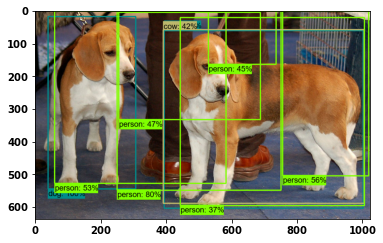

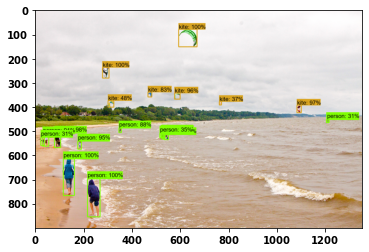

In [46]:
for image_path in TEST_IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detection_model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)    
    print('Done')
plt.show()

##### GREAT! Seems like everything is working as intended. Next is to set up a a live webcam with output predictions.

## 13 - WebCam Implementation:

This section follows the tutorial on: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html

MODEL SELECTED -> faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8

Folder: D:\TensorFlow ObjDetection API\workspace\Faster-RCNN_Webcam

NOTE: os.getcwd() =  D:\TensorFlow ObjDetection API\

#### Create the Data and Model Directory:

This is where everything will be saved.


In [47]:
DATA_DIR = os.path.join(os.getcwd(), 'workspace\Faster-RCNN_Webcam')
MODELS_DIR = os.path.join(DATA_DIR, 'models')
for dir in [DATA_DIR, MODELS_DIR]:
    if not os.path.exists(dir):
        os.mkdir(dir)

#### Download the Model:

In [48]:
import tarfile
import urllib.request

# Download and extract model
MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8'
MODEL_TAR_FILENAME = MODEL_NAME + '.tar.gz'
MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
MODEL_DOWNLOAD_LINK = MODELS_DOWNLOAD_BASE + MODEL_DATE + '/' + MODEL_TAR_FILENAME
PATH_TO_MODEL_TAR = os.path.join(MODELS_DIR, MODEL_TAR_FILENAME)
PATH_TO_CKPT = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'checkpoint/'))
PATH_TO_CFG = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'pipeline.config'))

if not os.path.exists(PATH_TO_CKPT):
    print('Downloading model. This may take a while... ', end='')
    urllib.request.urlretrieve(MODEL_DOWNLOAD_LINK, PATH_TO_MODEL_TAR)
    tar_file = tarfile.open(PATH_TO_MODEL_TAR)
    tar_file.extractall(MODELS_DIR)
    tar_file.close()
    os.remove(PATH_TO_MODEL_TAR)
    print('Done')

# Download labels file
LABEL_FILENAME = 'mscoco_label_map.pbtxt'
LABELS_DOWNLOAD_BASE = \
    'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
PATH_TO_LABELS = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, LABEL_FILENAME))
if not os.path.exists(PATH_TO_LABELS):
    print('Downloading label file... ', end='')
    urllib.request.urlretrieve(LABELS_DOWNLOAD_BASE + LABEL_FILENAME, PATH_TO_LABELS)
    print('Done')

#### Load in the Model:

In [49]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

#### Load in the Label Map Data for Visualisation:

In [50]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

## 13.1 - Run the video stream:

Use OpenCV to capture the video stream generated by our webcam.

In [51]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

# Raise an error message if webcam cannot be found:
if not cap.isOpened():
    raise IOError("Webcam was not detected. Detection Terminated.")

while True:
    # Read frame from camera
    ret, image_np = cap.read()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # Display output
    cv2.imshow('object detection', cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Source: 
- https://www.analyticsvidhya.com/blog/2018/12/practical-guide-object-detection-yolo-framewor-python/
- https://manalelaidouni.github.io/manalelaidouni.github.io/Understanding%20YOLO%20and%20YOLOv2.html
- https://appsilon.com/object-detection-yolo-algorithm/
- http://datahacker.rs/how-to-peform-yolo-object-detection-using-keras/
- http://datahacker.rs/tensorflow2-0-yolov3/
- https://github.com/zzh8829/yolov3-tf2
- https://github.com/AlexeyAB/darknet

## Summary:

From this project, I was able to learn a great deal about the YOLO architecture and how it was able to draw bounding boxes around the objects of interests with impressive speeds.The most complex part of this project had to be the losses computation involving the bounding box coordinates and its size, confidence that the object was in the box, the scores for each of the classes and the full combination of the YOLO loss altogether. I was able to quickly implement the model inference with the webcam on a CPU only machine with the help of the OpenCV library. This project also introduced new concepts such as Average Precision Threshold, known as the Jaccard Index (or Intersection over Union, IoU) and the achor boxes was refined with a few equations and its subsequent post processing whereby using NMS to remove unwanted bounding boxes. The overall process was highly challenging and rewarding. For future works, I intend to venture into Faster R-CNNs to find out how it differs, why is it considered to be faster than YOLO and hopefully, be able to implement it in TensorFlow or Keras.
